In [1]:
import os
os.chdir("..")

In [2]:
from lib import *
from keras.models import load_model
import csv


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
model = load_model('model-segmentation-3.3.h5', custom_objects={'mean_iou':mean_iou})





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 240, 240, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
BATCH_SIZE = 10 
# memory issues on 8 gig container
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train'
TRAIN_MASK_PATH = 'data/train_mask'

VALIDATE_PATH = 'data/valid'
VALIDATE_MASK_PATH = 'data/valid_mask'

TEST_PATH = 'data/test'

seed = 83

images = os.listdir(TRAIN_PATH)
val_images = os.listdir(VALIDATE_PATH)
test_images = os.listdir(TEST_PATH)

In [6]:
X_train, Y_train = get_xy(images, TRAIN_PATH, TRAIN_MASK_PATH)
X_validate, Y_validate = get_xy(val_images, VALIDATE_PATH, VALIDATE_MASK_PATH)
X_test, Y_test_placeholder = get_xy(test_images, TEST_PATH)

In [21]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

def predict_mask(model, X_, img_height=320, img_width=240):
    """ predict the mask for a given image and resize it to the provided img_height and img_width

    Parameters
    ----------
    model : keras.model
        model to use to predict the mask
    X_ : (np.ndarray, 4d )
        array of source images in np.ndarray form 
    img_height : int, optional (default=340)
        output image mask height
    img_width : int, optional (default=240)
        output image mask width
    Returns
    -------
    ((np.ndarray, 4d), (np.ndarray, 3d))
        the array of reshaped X_ and array of predicted masks reshaped to to the provided dimensions
    """
    length_test = len(X_)

    Y_ = np.zeros((length_test , img_height, img_width), dtype=np.uint8)
    X_320_240 = np.zeros((length_test , img_height, img_width, 3), dtype=np.uint8)
    for i in range(length_test):
        y_ = model.predict(X_[i][None,:,:,:])[0]
        y_ = (y_.squeeze()*255).astype(np.uint8)

        Y_[i] = resize(y_, (320, 240), mode='constant', 
                                              preserve_range=True).astype(np.uint8)


        X_320_240[i] = resize(X_[i], (320, 240, 3), mode='constant', 
                                              preserve_range=True).astype(np.uint8)

    return (X_320_240, Y_)

In [22]:
X_valid_320_240, Y_valid_predicted = predict_mask(model, X_validate)

In [23]:
Y_valid_predicted[0].shape

(320, 240)

In [24]:
from skimage.transform import resize

length_validate = len(Y_validate)
Y_validate_320_240 = np.zeros((length_validate, 320, 240), dtype=np.uint8)
for i in range(length_validate):
        Y_validate_320_240[i] = resize(Y_validate[i], (320, 240), mode='constant', 
                                              preserve_range=True).astype(np.uint8)[:,:,0]



## check avaerage dice metric

In [25]:
get_dice(Y_validate_320_240, Y_valid_predicted)

0.8020334242731724

In [30]:
from skimage.io import imread, imshow
from matplotlib import pyplot as plt

for i in range(length_validate):
    img_id = val_images[i].split(".")[0]    
    plt.imsave(f'data/valid_pred_mask/{img_id}.png', Y_valid_predicted[i])    

In [41]:
from PIL import Image
path = "data/valid"
vv_images = os.listdir(path)
ind = np.random.choice(vv_images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_pred_mask/{ind}.png"))

encode_rle(mask[:,:,0])

(320, 240)


'1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258 1 328 1 330 1 332 1 334 1 336 1 338 1 340 1 342 1 344 1 346 1 348 1 350 1 352 1 354 3 360 1 362 1 366 7 374 1 376 1 378 1 381 10 392 1 394 11 406 1 408 1 410 1 413 60 477 2 480 1 483 3 490 16 526 161 689 24 717 2 720 1 722 2 727 5 850 1 861 8 877 8 894 42 937 1 939 1 941 3 951 6 959 2 962 1 966 5 1101 8 1118 7 1136 23 1160 14 1182 1 1192 6 1199 2 1202 1 1205 5 1345 1 1361 1 1389 5 1407 2 1433 3 1437 2 1441 3 1449 136 1586 15 1602 27 1634 43 1679 2 1682 1 1686 137 1826 43 1874 43 1919 2 1922 1 1926 137 2066 43 2114 43 2159 2 2162 1 2166 137 2306 43 2354 41 2396 1 2398 1 2401 1 2404 139 2546 43 2595 10 2609 24 2638 1 2641 1 2644 139 2786 41 2835 8 2849 24 2877 2 2880 1 2882 2 3023 3 3067 8 3083 6 3113 4 3119 1 3121 1 3123 138 3267 40 3317 4 3331 21 3357 3 3361 1 3363 135 3508 9 3522 23 3571 22 3597 3 3601 1 3603 134 3748 8 3763 21 3812 23 3838 2 3841 1 3843 134 3988 8 4003 21 4052 23 4078 2 4081 135 4244 20 4293 24 4319 1 4321 132 4485 16 4

In [48]:
pred_valid_csv = []

for i in range(len(val_images)):
    img_id = val_images[i].split(".")[0]
    mask = np.array(Image.open(f"{path}_pred_mask/{ind}.png"))
    pred_valid_csv.append({'id': img_id, 'rle_mask': encode_rle(mask[:,:,0])})


In [49]:
pred_valid_csv[0]

{'id': '1409',
 'rle_mask': '1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258 1 328 1 330 1 332 1 334 1 336 1 338 1 340 1 342 1 344 1 346 1 348 1 350 1 352 1 354 3 360 1 362 1 366 7 374 1 376 1 378 1 381 10 392 1 394 11 406 1 408 1 410 1 413 60 477 2 480 1 483 3 490 16 526 161 689 24 717 2 720 1 722 2 727 5 850 1 861 8 877 8 894 42 937 1 939 1 941 3 951 6 959 2 962 1 966 5 1101 8 1118 7 1136 23 1160 14 1182 1 1192 6 1199 2 1202 1 1205 5 1345 1 1361 1 1389 5 1407 2 1433 3 1437 2 1441 3 1449 136 1586 15 1602 27 1634 43 1679 2 1682 1 1686 137 1826 43 1874 43 1919 2 1922 1 1926 137 2066 43 2114 43 2159 2 2162 1 2166 137 2306 43 2354 41 2396 1 2398 1 2401 1 2404 139 2546 43 2595 10 2609 24 2638 1 2641 1 2644 139 2786 41 2835 8 2849 24 2877 2 2880 1 2882 2 3023 3 3067 8 3083 6 3113 4 3119 1 3121 1 3123 138 3267 40 3317 4 3331 21 3357 3 3361 1 3363 135 3508 9 3522 23 3571 22 3597 3 3601 1 3603 134 3748 8 3763 21 3812 23 3838 2 3841 1 3843 134 3988 8 4003 21 4052 23 4078 2 4081 135 4244 20 4293 

## create result 1, csv 

In [50]:
csv_columns = ['id','rle_mask']
csv_file = "data/pred_valid_template.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in pred_valid_csv:
            writer.writerow(data)
except IOError:
    print("I/O error") 


In [51]:
import pandas as pd
df = pd.read_csv(csv_file)
df.head()

,id,rle_mask
0,1409,1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258...
1,1353,1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258...
2,1435,1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258...
3,1421,1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258...
4,1347,1 1 3 2 9 1 11 221 237 1 239 2 243 2 250 7 258...


## check random masks

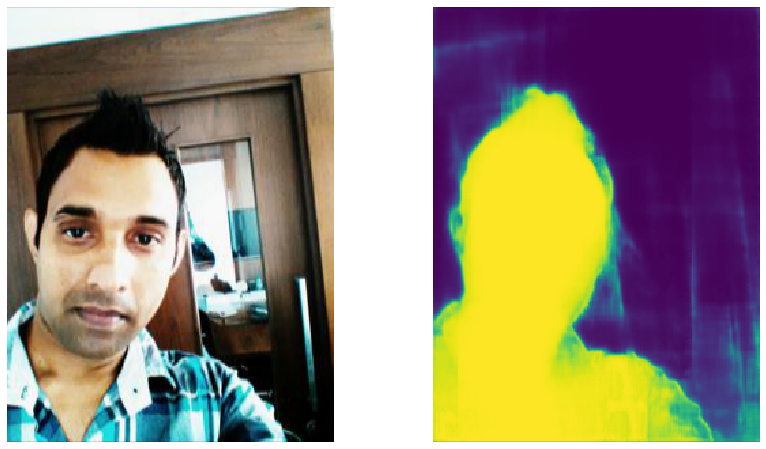

In [52]:
random_index = np.random.choice(X_validate.shape[0])
show_img_with_mask(X_valid_320_240[random_index], Y_valid_predicted[random_index])

In [53]:
X_test_320_240, Y_test_predicted = predict_mask(model, X_test)

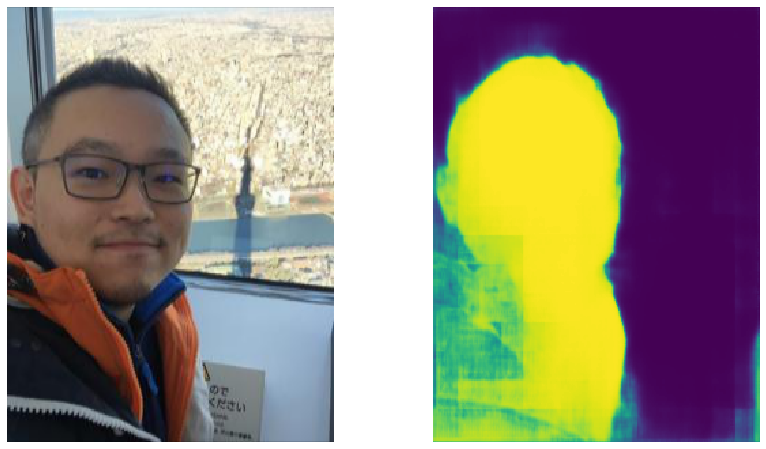

In [54]:
random_index = np.random.choice(X_test.shape[0])
show_img_with_mask(X_test_320_240[random_index], Y_test_predicted[random_index])

## write images

In [55]:
length_test = len(test_images)
for i in range(length_test):
    img_id = test_images[i].split(".")[0]    
    plt.imsave(f'data/test_mask/{img_id}.png', Y_test_predicted[i])    

In [56]:

from glob import glob

paths_to_imgs = sorted(glob("data/test/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/test_mask/*"))]


NameError: name 'glob' is not defined

In [ ]:
_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/test")